<a href="https://colab.research.google.com/github/marckbarrion/Applied-AI-Tutorials/blob/main/AAT_1_Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 Deep Learning Dog Breed Identification

**Welcome to the Applied AI Tutorials Dog Breed Classifier!**

This is a perfect, hands-on project for learning the fundamentals of modern computer vision. Our goal is to build a model that can look at a picture of a dog and correctly identify its breed from 120 possibilities.

This is a challenging problem called **fine-grained classification** because many breeds look very similar (e.g., a Norfolk Terrier vs. a Norwich Terrier).

To solve this, we will use a powerful technique called **Transfer Learning** with one of the best-performing models available: **EfficientNet**.

Let's get started!

## Step 1: Setup the Colab Environment

First, we need to get our data from the Kaggle competition. We'll use the Kaggle API to download it directly into our Colab notebook.

### 1.1. Install the Kaggle API

This command installs the necessary Python package to interact with Kaggle.

In [1]:
!pip install -q kaggle

### 1.2. Upload Your Kaggle API Token

To use the Kaggle API, you need to authenticate.

1.  Go to your Kaggle account page: [https://www.kaggle.com/account](https://www.kaggle.com/account)
2.  Scroll down to the "API" section.
3.  Click `Create New API Token`. This will download a file named `kaggle.json`.
4.  Run the code cell below. It will show an "Upload" button. Click it and select the `kaggle.json` file you just downloaded.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marckherzonbarrion","key":"7855d1d9db83fb5f72e643c49e5c0d6f"}'}

### 1.3. Configure the API Token

Now we'll move the `kaggle.json` file to the correct directory and set its permissions so the Kaggle API can find and use it.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### 1.4. Download and Unzip the Dataset

With the API ready, we can download the data for the "Dog Breed Identification" competition. This might take a minute or two.

After downloading, we'll unzip the `train.zip` and `test.zip` files. We only care about the images, so we'll use the `-q` (quiet) flag to avoid printing all the filenames.

In [4]:
!kaggle competitions download -c dog-breed-identification
!unzip -q dog-breed-identification.zip -d dog-breed-identification
# print("Unzipping training images...")
# !unzip -q train.zip -d train
# print("Unzipping test images...")
# !unzip -q test.zip -d test
# print("Data is ready!")

 97% 669M/691M [00:00<00:00, 1.75GB/s]
100% 691M/691M [00:00<00:00, 1.74GB/s]


## Step 2: Load and Prepare the Data

Now we'll use **Pandas** to load the `labels.csv` file, which tells us the breed for each image in the training set.

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os

# Load the labels
labels_df = pd.read_csv('dog-breed-identification/labels.csv')

# Check the first 5 rows
print(labels_df.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


### 2.1. Check the Data

Let's see how many breeds we have and how many images per breed.

In [6]:
num_breeds = labels_df['breed'].nunique()
print(f"Total number of unique breeds: {num_breeds}")

# Show the distribution of breeds (top 10)
print("\nTop 10 most common breeds:")
print(labels_df['breed'].value_counts().head(10))

Total number of unique breeds: 120

Top 10 most common breeds:
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: count, dtype: int64


### 2.2. Preprocess Labels and File Paths

The model can't understand text labels like "boston_bull". We need to convert them into numbers. The best way for this kind of problem is **One-Hot Encoding**.

A one-hot encoded vector is a vector of all zeros, except for a single '1' at the index corresponding to the class. For 120 breeds, it will be a 120-element vector.

1.  We'll create a full file path for each image (e.g., `train/000bec180eb18c7604dcecc8fe0dba07.jpg`).
2.  We'll one-hot encode the `breed` column.
3.  We'll get a list of all the breed names (classes) in alphabetical order. This is **CRITICAL** for the final submission, as Kaggle expects the columns to be in this order.

In [7]:
# Create a column for the full image file path
labels_df['filename'] = 'dog-breed-identification/train/' + labels_df['id'] + '.jpg'

# Get the list of unique breed names (our classes)
# We sort them alphabetically to ensure consistent order
CLASSES = sorted(labels_df['breed'].unique())
num_classes = len(CLASSES)

# Create the one-hot encoded labels
# We use pandas.get_dummies which does this automatically
labels_one_hot = pd.get_dummies(labels_df['breed'], columns=CLASSES)

# Concatenate the one-hot labels back with the original dataframe
data_df = pd.concat([labels_df, labels_one_hot], axis=1)

print(f"Total classes: {num_classes}")
print("Dataframe with file paths and one-hot labels:")
print(data_df.head())

Total classes: 120
Dataframe with file paths and one-hot labels:
                                 id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                            filename  affenpinscher  \
0  dog-breed-identification/train/000bec180eb18c7...          False   
1  dog-breed-identification/train/001513dfcb2ffaf...          False   
2  dog-breed-identification/train/001cdf01b096e06...          False   
3  dog-breed-identification/train/00214f311d5d224...          False   
4  dog-breed-identification/train/0021f9ceb3235ef...          False   

   afghan_hound  african_hunting_dog  airedale  \
0         False                False     False   
1         False                False     False   
2         False

### 2.3. Create Training and Validation Sets

We need to split our data.
* **Training Set (80%):** The model learns from these images.
* **Validation Set (20%):** We use this to check the model's performance on unseen data during training. This helps us know if the model is *overfitting*.

We will store the filenames (X) and the one-hot labels (y).

In [8]:
# Get filenames as our features (X)
X = data_df['filename']

# Get the one-hot encoded labels as our target (y)
# We convert to numpy array as this is what tf.data expects
y = data_df[CLASSES].values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2, # 20% for validation
    random_state=42 # for reproducible results
)

print(f"Training images: {len(X_train)}")
print(f"Validation images: {len(X_val)}")

Training images: 8177
Validation images: 2045


## Step 3: Build an Efficient Data Pipeline (tf.data)

Loading 10,000+ images into memory at once is a bad idea. We'll use `tf.data` to build a high-performance pipeline that loads, preprocesses, and batches data on the fly.

### 3.1. Define Image Preprocessing

We need to:
1.  Read the image file from disk.
2.  Decode it as a JPEG.
3.  Resize all images to a standard size. `(224, 224)` is a common size for models like EfficientNet.
4.  Normalize the pixel values from `[0, 255]` to `[0, 1]`. This helps the model train faster.

In [9]:
IMG_SIZE = 300
BATCH_SIZE = 128 # Number of images to process at a time

def load_and_preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # We no longer normalize to [0, 1]. We will let the model do it.
    return image, label

### 3.2. Create the Datasets

Now we'll apply this function to our training and validation sets.

* `tf.data.Dataset.from_tensor_slices`: Creates a dataset from our filenames and labels.
* `.map()`: Applies our `load_and_preprocess_image` function to every item.
* `.shuffle()`: Randomizes the training data to help the model generalize.
* `.batch()`: Groups images into batches.
* `.prefetch()`: Pre-loads the next batch while the current one is being processed by the GPU. This is a key performance optimization.

In [10]:
# Create the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(X_train))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Step 4: Build the Model (Transfer Learning)

We have ~85 images per breed. Training a model from scratch is nearly impossible.

Instead, we'll use **Transfer Learning**. We'll use a model that has already been trained on millions of images from the "ImageNet" dataset (which includes many dogs). This model, `EfficientNetB0`, is already an expert at seeing shapes, textures, and patterns.

Our plan:
1.  **Load `EfficientNetB0`** without its final classification layer (`include_top=False`).
2.  **Freeze** the base model. We don't want to change its learned weights, just use them.
3.  **Add our own classifier** on top. This *new* part of the model will learn to take the features from EfficientNet and map them to our 120 dog breeds.
4.  **Add Data Augmentation** layers. This randomly flips, rotates, and zooms images during training, which creates more data for our model and prevents overfitting.

In [12]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow import keras

# assumes IMG_SIZE and num_classes are already defined

def create_model():
    # 1) Data Augmentation
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ], name="data_augmentation")

    # 2) Input
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_layer")

    # 3) Apply augmentation
    x = data_augmentation(inputs)

    # 4) EfficientNetB3 backbone
    # IMPORTANT: do NOT set a custom `name` here, so weights download uses the standard filename.
    backbone = EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_tensor=x,          # feeds augmented images into the backbone
        # name left as default to avoid 403 on weights download
    )
    backbone.trainable = False  # freeze for phase 1

    # OPTIONAL: wrap the backbone to give it a stable, findable name for fine-tuning later
    base = Model(backbone.input, backbone.output, name="efficientnetb3_base")

    # 5) Classifier head
    x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(base.output)
    x = layers.Dense(512, activation="relu", name="dense_layer")(x)
    x = layers.Dropout(0.5, name="dropout_layer")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    # 6) Assemble model
    model = Model(inputs, outputs, name="dogbreed_efficientnetb3")
    return model

# Build it
model = create_model()
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "dogbreed_efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati

 Total params: 11,632,039 (44.37 MB)

 Trainable params: 848,504 (3.24 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## Step 5: Compile and Train the Model

Now we configure the model for training.

* **Loss Function:** `CategoricalCrossentropy`. This is the mathematical formula for the competition's **Multi-Class Log Loss**.
* **Optimizer:** `Adam`. A smart optimizer that adjusts the learning rate automatically.
* **Metrics:** We'll track `accuracy` to see how we're doing in a human-understandable way.

We will also use **Callbacks**:
* `ModelCheckpoint`: Saves the *best* version of the model (lowest validation loss).
* `EarlyStopping`: Stops training if the model isn't improving, saving us time.

In [13]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0005), # <--- SETS A GOOD STARTING RATE
    metrics=['accuracy']
)

# Define callbacks
checkpoint_path = "best_model.keras"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss', # Save the model with the best validation loss
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True
)

### 5.1. Start Training (Phase 1: Feature Extraction)

We'll train the model for 25 epochs. In this phase, we are *only* training the new classifier head we added. The EfficientNet base is frozen.

This will be fast. Go grab a coffee! ☕

In [14]:
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.1992 - loss: 4.1749
Epoch 1: val_loss improved from inf to 1.48470, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - accuracy: 0.2020 - loss: 4.1631 - val_accuracy: 0.8582 - val_loss: 1.4847
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6849 - loss: 1.4940
Epoch 2: val_loss improved from 1.48470 to 0.49086, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.6851 - loss: 1.4912 - val_accuracy: 0.9081 - val_loss: 0.4909
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7382 - loss: 0.9844
Epoch 3: val_loss improved from 0.49086 to 0.34760, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.7384 - loss: 0.9835 - val_accuracy: 0.9203 - val_loss: 0.3476
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7709 - loss: 0.8124
Epoch 4: val_loss improved from 0.34760 to 0.30104,

### 5.2. Plot Training History

Let's see how our model did.

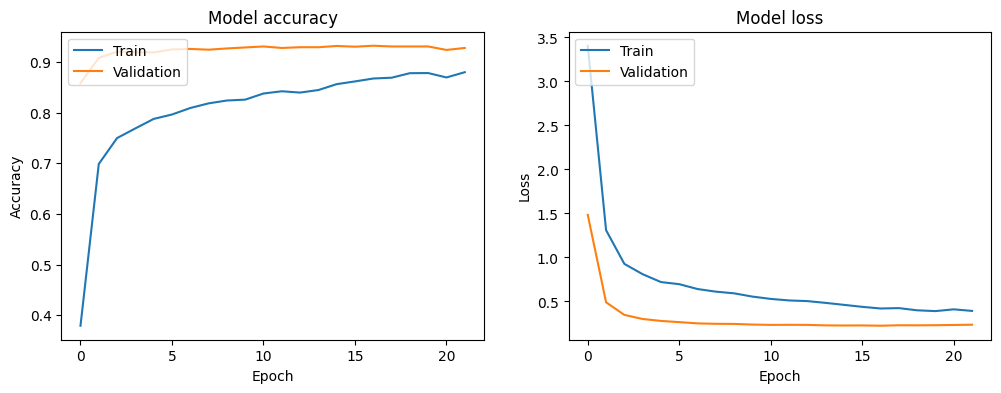

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

## Step 6: Fine-Tuning the Model (Optional, but Recommended)

Our model is doing great! The validation accuracy is high, showing that our classifier head has learned to interpret the features from EfficientNet.

Now, we can *unfreeze* the top layers of the `EfficientNet` base model and train them with a **very low learning rate**. This "fine-tunes" the pre-trained features to be even better at our specific task (dog breeds) without destroying the valuable knowledge they already have.

1.  **Load** the best model we saved.
2.  **Unfreeze** the base model.
3.  **Re-compile** with a *tiny* learning rate.
4.  **Continue training**.

In [16]:
import tensorflow as tf
from tensorflow import keras

# 1) Load the best model saved by our checkpoint
model = keras.models.load_model(checkpoint_path)

# 2) Choose a safe fine-tuning strategy:
#    - Prefer the explicitly named base "efficientnetb3_base" (from your create_model()).
#    - If that isn't present (older checkpoints), fall back to pattern matching on EfficientNet blocks.
unfrozen_count = 0

try:
    base = model.get_layer("efficientnetb3_base")
    # Freeze everything first for safety
    for layer in base.layers:
        layer.trainable = False

    # PARTIAL UNFREEZE: only the top blocks (common fine-tune recipe)
    for layer in base.layers:
        # Unfreeze only the highest blocks (adjust as you like)
        if layer.name.startswith(("block6", "block7")):
            # Keep BatchNorms frozen for training stability
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True
                unfrozen_count += 1
except ValueError:
    # No named base found — fall back to pattern on the whole model
    for layer in model.layers:
        if layer.name.startswith(("block6", "block7")):
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True
                unfrozen_count += 1
        else:
            layer.trainable = False

print(f"Layers set trainable for fine-tuning: {unfrozen_count}")

# 3) (Optional) be sure your augmentation stays non-trainable
aug = model.get_layer("data_augmentation") if "data_augmentation" in [l.name for l in model.layers] else None
if aug is not None:
    aug.trainable = False

# 4) Re-compile with a very small LR (fine-tuning)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

# 5) Inspect the model
model.summary()


Layers set trainable for fine-tuning: 93


Model: "dogbreed_efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati

 Total params: 11,632,039 (44.37 MB)

 Trainable params: 7,862,974 (29.99 MB)

 Non-trainable params: 3,769,065 (14.38 MB)

### 6.1. Start Training (Phase 2: Fine-Tuning)

Let's train for 10 more epochs. We'll re-use our `EarlyStopping` callback to make sure we stop if performance gets worse.

In [17]:
# We will continue training from where we left off
# We'll use a new checkpoint file for the fine-tuned model
fine_tune_checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model_fine_tuned.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# We need a new EarlyStopping callback as well
early_stopping_fine_tune = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_fine_tune = model.fit(
    train_ds,
    epochs=35, # Train up to epoch 35
    validation_data=val_ds,
    # We continue from the last epoch of the previous training
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[fine_tune_checkpoint, early_stopping_fine_tune]
)

Epoch 23/35
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8698 - loss: 0.4033
Epoch 23: val_loss improved from inf to 0.22638, saving model to best_model_fine_tuned.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.8698 - loss: 0.4032 - val_accuracy: 0.9315 - val_loss: 0.2264
Epoch 24/35
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8738 - loss: 0.3867
Epoch 24: val_loss improved from 0.22638 to 0.22634, saving model to best_model_fine_tuned.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.8738 - loss: 0.3866 - val_accuracy: 0.9291 - val_loss: 0.2263
Epoch 25/35
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8868 - loss: 0.3419
Epoch 25: val_loss did not improve from 0.22634
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.8867 - loss: 0.3422 - val_accuracy: 0.9286 - val_loss: 0.2272
Epoch 26/35
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8939 - loss: 0.3395
Epoch 26: val_loss did not improve from 0.22634
64/64 ━━━━━━

## Step 7: Create Submission File

The model is trained! Now we must predict the breed for all the images in the `test` folder and format our predictions into a `submission.csv` file, just like the `sample_submission.csv`.

Builds the test pipeline and loads the model.  

In [24]:
import os
import tensorflow as tf
from tensorflow import keras

# constants from training:
# IMG_SIZE = 300
# BATCH_SIZE = 128
# CLASSES = sorted(labels_df['breed'].unique())

# 1) Load fine-tuned model
best_model = keras.models.load_model("best_model_fine_tuned.keras")

# 2) Collect test file paths and ids
test_dir = "dog-breed-identification/test"
if not os.path.isdir(test_dir):
    raise FileNotFoundError(f"Expected folder not found: {test_dir}")

test_filenames = sorted(
    os.path.join(test_dir, f)
    for f in os.listdir(test_dir)
    if f.lower().endswith(".jpg")
)
test_ids = [os.path.splitext(os.path.basename(p))[0] for p in test_filenames]
print(f"Found {len(test_filenames)} test images.")

# 3) Build tf.data pipeline (match training preprocessing: no /255.0, no extra preprocess_input)
def _load_test_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

test_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_ds.map(_load_test_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Found 10357 test images.


Generates predictions and saves the `submission.csv` file.

In [25]:
import numpy as np
import pandas as pd

# Predict
preds = best_model.predict(test_ds, verbose=1)

# Sanity: ensure class count matches
assert preds.shape[1] == len(CLASSES), (
    f"Pred classes={preds.shape[1]} vs CLASSES={len(CLASSES)}. "
    "Use the exact CLASSES list from training."
)

# Build submission (id first, then CLASSES in same order)
submission = pd.DataFrame(preds, columns=CLASSES)
submission.insert(0, "id", test_ids)

# Save clean CSV
submission.to_csv("submission.csv", index=False, float_format="%.6f")
print("Saved submission.csv:", submission.shape)


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step
Saved submission.csv: (10357, 121)
